<a href="https://colab.research.google.com/github/syedshubha/TeachingQuantumComputing/blob/main/BB84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install --quiet qiskit qiskit-aer pylatexenc  &> /dev/null

In [ ]:
from qiskit import *
from random import *
from qiskit_aer import *
import numpy as np
import time
import matplotlib.pyplot as plt

# BB84 Protocol Demonstration

## Alice Encoding

In [ ]:
def alice_encode(basis, eig):
  n = len(basis)
  QC = []
  for i in range(n):
    qc = QuantumCircuit(1,1)
    if eig[i]==1:
      qc.x(0)
    if basis[i]==1:
      qc.h(0)
    QC.append(qc)
  return QC

## Eve

In [ ]:
def eavesdropping(QC, intercept_prob=1.0):
  n = len(QC)
  k = int(intercept_prob * n)
  eve_measures = sample(range(n), k)
  for i in eve_measures:
    basis = randint(0,1)
    if basis ==1:
      QC[i].h(0)
    QC[i].measure(0,0)
  return QC

## Bob decoding

In [ ]:
def bob_decode(basis, QC):
  n = len(QC)
  for i in range(n):
    if basis[i]==1:
      QC[i].h(0)
    QC[i].measure(0,0)
  bob_result = ""
  simulator = Aer.get_backend('aer_simulator')
  result = simulator.run(transpile(QC, simulator), shots=1).result()
  for i in range(n):
    counts = result.get_counts()
    bob_result += list(counts[i].keys())[0]
  return bob_result

## Key Matching

In [ ]:
def key(alice_basis, bob_basis, alice_eig, bob_result):
  match = []
  n = min(len(alice_basis), len(bob_basis), len(alice_eig), len(bob_result))
  alice_key = ""
  bob_key = ""
  for i in range(n):
    if alice_basis[i]==bob_basis[i]:
      match.append(i)
      alice_key = alice_key + str(alice_eig[i])
  for i in match:
    bob_key = bob_key + bob_result[i]
  return alice_key, bob_key

## No Eavesdropping

In [ ]:
n = 30
alice_basis = choices([0,1], k=n)
alice_eig = choices([0,1], k=n)
bob_basis = choices([0,1], k=n)
Q = alice_encode(alice_basis, alice_eig)
bob_result = bob_decode(bob_basis, Q)
alice_key, bob_key = key(alice_basis, bob_basis, alice_eig, bob_result)
print(alice_key)
print(bob_key)

0001111011110011
0001111011110011


In [ ]:
print(alice_key == bob_key)

True


## Eavesdropping

In [ ]:
eavesdropped_states = eavesdropping(Q, 1.0)
bob_result = bob_decode(bob_basis, eavesdropped_states)
alice_key, bob_key = key(alice_basis, bob_basis, alice_eig, bob_result)
print(alice_key)
print(bob_key)

0001111011110011
0000101001100111


In [ ]:
alice_key == bob_key

False

# CASCADE PROTOCOL

In [ ]:
def sifting(alice_basis, bob_basis, alice_eig, bob_result):
    """
    Sifts the keys. Returns the raw keys (strings).
    """
    n = min(len(alice_basis), len(bob_basis), len(alice_eig), len(bob_result))
    alice_key_str = ""
    bob_key_str = ""

    for i in range(n):
        if alice_basis[i] == bob_basis[i]:
            alice_key_str += str(alice_eig[i])
            bob_key_str += bob_result[i]

    return alice_key_str, bob_key_str

In [ ]:
def get_parity(block):
    return sum(block) % 2

def get_shuffled_indices(length, seed_val):
    indices = list(range(length))
    rnd = Random(seed_val)
    rnd.shuffle(indices)
    return indices

In [ ]:
def binary_search_correction(alice_vals, bob_vals, original_indices):
    """
    Recursively finds the error.
    alice_vals/bob_vals: The actual bit values (integers)
    original_indices: The index in the master key that these bits correspond to
    """
    n = len(alice_vals)

    # Base Case: Found the specific bit
    if n == 1:
        return original_indices[0] # Return the index to flip

    mid = n // 2

    # Split Data
    left_alice = alice_vals[:mid]
    left_bob = bob_vals[:mid]

    # Parity Check on Left
    if get_parity(left_alice) != get_parity(left_bob):
        # Error is in Left
        return binary_search_correction(left_alice, left_bob, original_indices[:mid])
    else:
        # Error is in Right
        right_alice = alice_vals[mid:]
        right_bob = bob_vals[mid:]
        return binary_search_correction(right_alice, right_bob, original_indices[mid:])

In [ ]:
def run_cascade(alice_key_str, bob_key_str, num_passes=4, base_block_size=10):
    # Convert strings to integer lists for math operations
    alice_key = [int(b) for b in alice_key_str]
    bob_key = [int(b) for b in bob_key_str]

    n = len(alice_key)
    total_leaked_bits = 0

    for pass_num in range(1, num_passes + 1):
        # Determine block size for this pass
        block_size = base_block_size if pass_num == 1 else base_block_size * (2**(pass_num-1))

        # Generate permutation for this pass
        # We work on INDICES so we can flip the bit in the main 'bob_key' list correctly
        if pass_num > 1:
            shuffled_indices = get_shuffled_indices(n, seed_val=pass_num)
        else:
            shuffled_indices = list(range(n))

        # Process blocks
        for i in range(0, n, block_size):
            # Get the indices for this block
            block_indices = shuffled_indices[i : min(i + block_size, n)]

            # Extract the actual bits based on these indices
            block_alice = [alice_key[idx] for idx in block_indices]
            block_bob = [bob_key[idx] for idx in block_indices]

            # 1. Top Level Parity Check
            if get_parity(block_alice) != get_parity(block_bob):
                total_leaked_bits += 1

                # 2. Binary Search to find the exact index of error
                error_idx = binary_search_correction(block_alice, block_bob, block_indices)

                # 3. Flip the bit in Bob's main key
                bob_key[error_idx] = 1 - bob_key[error_idx]
                total_leaked_bits += np.ceil(np.log2(len(block_indices))) # Approx cost of binary search

    # Convert back to string for final output
    bob_final_str = "".join(str(b) for b in bob_key)
    return bob_final_str, total_leaked_bits

# Full Pipeline

In [ ]:
# True intercept-resend model
def eavesdropping(QC, intercept_prob=1.0):
    n = len(QC)
    k = int(intercept_prob * n)
    eve_measures = sample(range(n), k)

    for i in eve_measures:
        qc = QC[i]
        eve_basis = randint(0, 1)
        c = qc.cregs[0]

        # Measure in Eve's basis
        if eve_basis == 1:
            qc.h(0)
        qc.measure(0, c[0])

        # Re-prepare according to her outcome
        qc.reset(0)
        with qc.if_test((c, 1)):
          qc.x(0)  # prepare |1> if she saw 1

        # Send in the basis she used
        if eve_basis == 1:
            qc.h(0)

    return QC

In [ ]:
def binary_entropy(p):
    p = np.asarray(p, dtype=float)
    p = np.clip(p, 1e-12, 1 - 1e-12)
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)


def run_simulation(N=500, trials=5, steps=10):
    avg_qber = []
    avg_secure_key_rate = []
    intercept_probs = np.linspace(0, 1.0, steps)

    start_time = time.time()

    for i, prob in enumerate(intercept_probs):
        qber_list = []
        secure_rate_list = []

        for _ in range(trials):
            # 1. Setup
            alice_basis = choices([0,1], k=N)
            alice_eig = choices([0,1], k=N)
            bob_basis = choices([0,1], k=N)

            # 2. Quantum Layer (The Bottleneck)
            Q = alice_encode(alice_basis, alice_eig)
            Q_eve = eavesdropping(Q, intercept_prob=prob)
            bob_result_raw = bob_decode(bob_basis, Q_eve)

            # 3. Sifting
            alice_sifted, bob_sifted = sifting(alice_basis, bob_basis, alice_eig, bob_result_raw)
            n_sifted = len(alice_sifted)

            if n_sifted == 0:
                qber_list.append(0)
                secure_rate_list.append(0)
                continue

            # 4. QBER Calc
            errors = sum([1 for k in range(n_sifted) if alice_sifted[k] != bob_sifted[k]])
            QBER = errors / n_sifted
            qber_list.append(QBER)

            # 5. Cascade Leakage
            if errors > 0:
                _, leaked_bits = run_cascade(alice_sifted, bob_sifted)
            else:
                leaked_bits = 0

            # 6. Privacy Amplification & Key Rate
            # Key Rate R = (n_sifted - leakage - privacy_maintenance) / N_total
            privacy_cost = binary_entropy(QBER) * n_sifted
            final_secure_len = n_sifted - leaked_bits - privacy_cost

            if final_secure_len < 0: final_secure_len = 0
            secure_rate_list.append(final_secure_len / N)

        avg_qber.append(np.mean(qber_list))
        avg_secure_key_rate.append(np.mean(secure_rate_list))

    print(f"\nSimulation Complete in {time.time()-start_time:.2f}s")
    return intercept_probs, avg_qber, avg_secure_key_rate


Simulation Complete in 116.76s


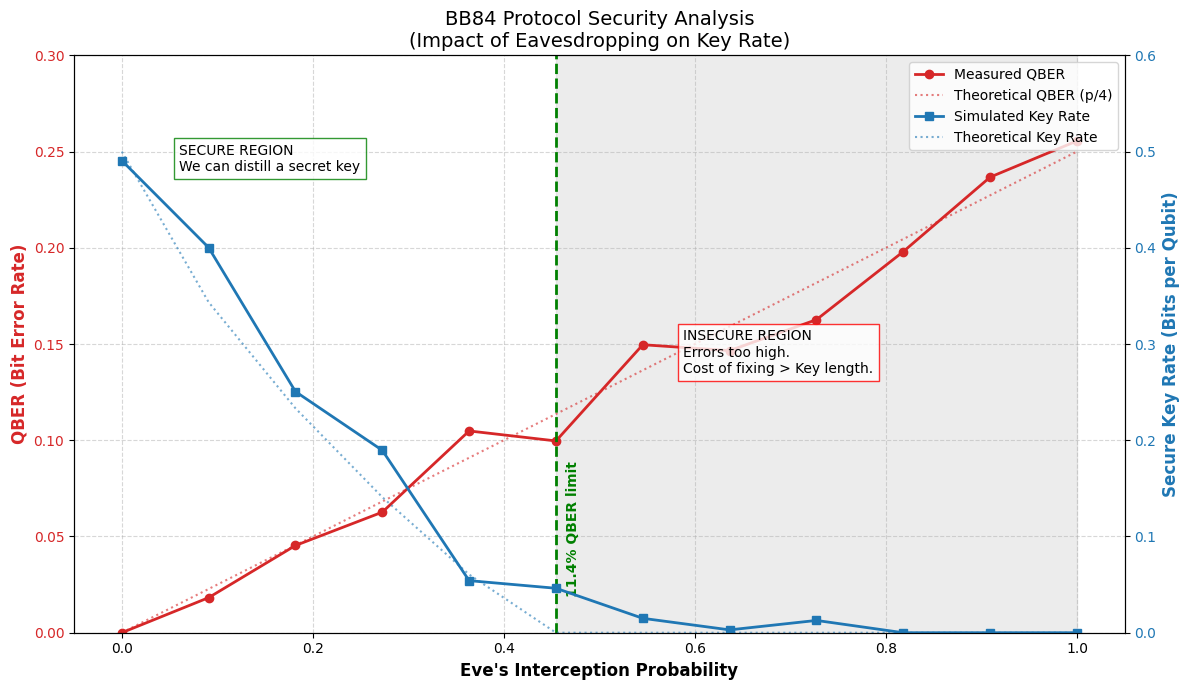

In [ ]:
# --- Run simulation ---
probs, qbers, rates = run_simulation(N=300, trials=5, steps=12)
probs = np.asarray(probs)
qbers = np.asarray(qbers)
rates = np.asarray(rates)

# --- Theoretical QBER & key-rate under intercept-resend attack ---

# Q_theory(p) = p/4 for BB84 intercept-resend
qber_theory = probs / 4.0

# Shor–Preskill bound: R_sifted = 1 - 2 H2(Q), per sifted bit
R_sifted_theory = 1.0 - 2.0 * binary_entropy(qber_theory)

# Per transmitted qubit (include sifting factor ~1/2) and clamp at 0
R_theory = 0.5 * np.maximum(0.0, R_sifted_theory)

# Find the interception probability where theoretical key rate crosses zero
eps = 1e-6
zero_idx = np.where(R_theory <= eps)[0]

if len(zero_idx) == 0:
    # Shouldn't happen for BB84, but fall back gracefully
    threshold_x = probs[-1]
else:
    k = zero_idx[0]
    if k == 0:
        threshold_x = probs[0]
    else:
        # Linear interpolation between the last positive and the first non-positive point
        x1, x2 = probs[k-1], probs[k]
        y1, y2 = R_theory[k-1], R_theory[k]
        threshold_x = x1 - y1 * (x2 - x1) / (y2 - y1)

# Corresponding QBER threshold for annotation (should be ≈ 0.11)
Q_threshold = threshold_x / 4.0

# --- Plotting ---

fig, ax1 = plt.subplots(figsize=(12, 7))

# 1. Left Axis: QBER
color_qber = '#D62728'  # Brick Red
ax1.set_xlabel("Eve's Interception Probability", fontsize=12, fontweight='bold')
ax1.set_ylabel('QBER (Bit Error Rate)', color=color_qber, fontsize=12, fontweight='bold')

ax1.plot(probs, qbers, color=color_qber, marker='o', linewidth=2, label='Measured QBER')
ax1.plot(probs, qber_theory, color=color_qber, linestyle=':', alpha=0.6,
         label='Theoretical QBER (p/4)')

ax1.tick_params(axis='y', labelcolor=color_qber)
ax1.set_ylim(0, max(0.3, 1.1 * qbers.max()))
ax1.grid(True, linestyle='--', alpha=0.5)

# 2. Right Axis: Key Rate
ax2 = ax1.twinx()
color_rate = '#1F77B4'  # Steel Blue
ax2.set_ylabel('Secure Key Rate (Bits per Qubit)', color=color_rate,
               fontsize=12, fontweight='bold')

ax2.plot(probs, rates, color=color_rate, marker='s', linewidth=2,
         label='Simulated Key Rate')
ax2.plot(probs, R_theory, color=color_rate, linestyle=':', alpha=0.6,
         label='Theoretical Key Rate')

ax2.tick_params(axis='y', labelcolor=color_rate)
ax2.set_ylim(0, max(0.6, 1.1 * rates.max()))

# 3. Security Threshold from theory (no hardcoding)
ax1.axvline(x=threshold_x, color='green', linestyle='--', linewidth=2)

# Shade the "Insecure" region (theory says R <= 0 here)
ax1.axvspan(threshold_x, probs[-1], color='gray', alpha=0.15)

# Annotations (use axes coordinates so it’s robust if ranges change)
ax1.text(0.10, 0.80, "SECURE REGION\nWe can distill a secret key",
         transform=ax1.transAxes,
         fontsize=10,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='green'))

ax1.text(0.58, 0.45, "INSECURE REGION\nErrors too high.\nCost of fixing > Key length.",
         transform=ax1.transAxes,
         fontsize=10,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='red'))

ax1.text(threshold_x + 0.01, 0.02,
         f"{Q_threshold*100:.1f}% QBER limit",
         color='green', fontweight='bold', rotation=90)

plt.title('BB84 Protocol Security Analysis\n(Impact of Eavesdropping on Key Rate)',
          fontsize=14)

fig.tight_layout()

# Merge legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.show()

# DH Algorithm

In [ ]:
# The Public Constants (Everyone knows these)
p = 134217689 # p should be a large prime, we are using a 32 bit prime
g = 7 # g: The generator, should be a primitive root to p

# The Private Keys (Only Alice/Bob know these)
# You can change these to any integer a,b < p
alice_private_key = randint(2, p-2)  # Let's call this 'a'
bob_private_key   = randint(2, p-2) # Let's call this 'b'

# Public_Key = (g ^ Private_Key) mod p
alice_public_key = pow(g, alice_private_key, p) # Let's call this 'A'
bob_public_key = pow(g, bob_private_key, p) # Let's call this 'B'

# Shared_Secret = (Other_Person_Public ^ My_Private) mod p
alice_shared_secret = pow(bob_public_key, alice_private_key, p)
bob_shared_secret = pow(alice_public_key, bob_private_key, p)

print(alice_shared_secret)

114408265


In [ ]:
alice_shared_secret == bob_shared_secret

True

In [ ]:
# ==========================================
# EVE'S ATTACK (The Discrete Log Problem)
# ==========================================
print(f"Eve knows: p={p}, g={g}, A = {alice_public_key}, B = {bob_public_key}")
print("Eve wants to find Alice's Private Key 'a' such that: g^a mod p = A, or Bob's Private Key 'b' such that: g^b mod p = B")

# Eve has to try every number starting from 1 until she finds a match.
start_time = time.time()

for candidate in range(1, p):
    # Check if g^candidate mod p matches Alice's public key
    check_val = pow(g, candidate, p)
    if check_val == alice_public_key:
        print(f"CRACKED! Found Private Key: {candidate}")
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Time taken: {elapsed_time:.5f} seconds")
        break

print(f"Eve now calculates {g}^{candidate}(mod{p})= {pow(g, candidate, p)}")

Eve knows: p=134217689, g=7, A = 103243485, B = 127046833
Eve wants to find Alice's Private Key 'a' such that: g^a mod p = A, or Bob's Private Key 'b' such that: g^b mod p = B
CRACKED! Found Private Key: 8678721
Time taken: 23.43249 seconds
Eve now calculates 7^8678721(mod134217689)= 103243485


Here p was a 32 bit prime. Imagine using RSA!

If we have a quantum computer, we could solve $g^x (mod p) = n$ using Quantum Phase Estimation (QPE) algorithm.